In [1]:
!git clone https://github.com/wlgh312/BSM_stylegan.git

Cloning into 'BSM_stylegan'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 201 (delta 72), reused 86 (delta 38), pack-reused 81
Receiving objects: 100% (201/201), 81.19 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (65/65), done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir /content/BSM_stylegan/raw_images

In [4]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 92kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566176 sha256=da92fca16773859bec75ee7086be8dbafc6475870d876d7323df9cd5fcb0338a
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [5]:
!pip install tqdm
!pip install typeguard
!pip install psutil
!pip install humanize
!pip install config
import cv2
import face_recognition
from IPython.display import Image
from google.colab import files
import pickle
import numpy as np
import PIL.Image
from PIL import Image
from shutil import copyfile
import config
from tqdm import tqdm
import matplotlib.pyplot as plt

  Created wheel for config: filename=config-0.4.2-cp36-none-any.whl size=15134 sha256=e5bc8b154f76ae73c9fef41c027d29c5f274482ede2f4fbbd92d872b86415b28
  Stored in directory: /root/.cache/pip/wheels/51/7d/db/0e38d2ec57843d00cc39f8df3686984ccec689694f7bc78a38
Successfully built config


In [6]:
import os
import sys
sys.path.append('/content/gdrive/My Drive/stylegan')
import dnnlib
import dnnlib.tflib as tflib#pre-trained networks
dnnlib.tflib.init_tf()

In [0]:
sys.path.insert(0, '/content/BSM_stylegan')
import ag_detection

In [0]:
entity_to_url={
        'faces':'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'
}
model_cache={}

In [0]:
def fetch_model(name):
  if model_cache.get(name):
    return model_cache[name]

  url = entity_to_url[name]
  with dnnlib.util.open_url(url, cache_dir='cache') as f:
    _G, _D, Gs = pickle.load(f)
    model_cache[name] = Gs
  return model_cache[name]

In [0]:
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=20)

In [11]:
seed=10000000
interpolate_dim=1#max:511
#mapping size
width=1#max:100
height=1
#image size
image_dim=100
interpolate=np.linspace(0, 30, width)
name='faces'
Gs=fetch_model(name)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def apply_latent_fudge(fudge, target_latent):
  copy=np.copy(target_latent)
  copy[interpolate_dim]+=fudge
  return copy

In [0]:
def v_linspace(i):
  v = np.array(list(map(lambda l: np.linspace(dst_dlatents[i][l], height), range(dst_dlatents.shape[1]))))
  v = v.transpose()
  return v

In [0]:
#dst:target image
def style_mixing(png, Gs, w, h, src_dlatents, dst_dlatents, style_ranges):
  print(png)
  src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
  dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

  canvas = PIL.Image.new('RGB', (w * (len(src_dlatents) + 1), h*(len(dst_dlatents) + 1)), 'white')
  for col, src_image in enumerate(list(src_images)):
    canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
  for row, dst_image in enumerate(list(dst_images)):
    canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
    row_dlatents = np.stack([dst_dlatents[row]] * len(src_dlatents))
    row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
    row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
    for col, image in enumerate(list(row_images)):
      canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
  canvas.save(png)
  return canvas.resize((512, 512))

In [0]:
#from google.colab.patches import cv2_imshow

In [0]:
dst_image = '/content/gdrive/My Drive/data/Man/benedict.jpg'
mix_image = '/content/gdrive/My Drive/data/style_result/mix_result.png'

In [0]:
test_file=np.load('/content/gdrive/My Drive/data/npy_result/benedict_01.npy')

age =  25-32 years
gender =  male


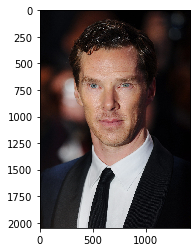

In [22]:
ag_detection.test(dst_image)
age=ag_detection.age
gender=ag_detection.gender
#print("age : {}".format(age))
#print("gender : ", gender)

0


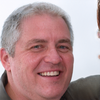

/content/BSM_stylegan



Using TensorFlow backend.
64045056/64040097 [==============================] - 5s 0us/step










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





58892288/58889256 [==============================] - 5s 0us/step


0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 203.1122; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 203.1122; lr 0.0100:   1% 1/100 [00:06<10:43,  6.50s/it]
seed_1: loss 177.5384; lr 0.0100:   1% 1/100 [00:06<10:43,  6.50s/it]
seed_1: loss 177.5384; lr 0.0100:   2% 2/100 [00:06<07:36,  4.66s/it]
seed_1: loss 157.5708; lr 0.0100:   2% 2/100 [00:07<07:36,  4.66s/it]
seed_1: loss 157.5708

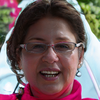

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 213.6201; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 213.6201; lr 0.0100:   1% 1/100 [00:06<10:31,  6.37s/it]
seed_1: loss 185.0638; lr 0.0100:   1% 1/100 [00:06<10:31,  6.37s/it]
seed_1: loss 185.0638; lr 0.0100:   2% 2/100 [00:06<07:27,  4.57s/it]
seed_1: loss 168.7613; lr 0.0100:   2% 2/100 [00:07<07:27,  4.57s/it]
seed_1: loss 168.7613; lr 0.0100:   3% 3/100 [00:07<05:20,  3.30s/it]
seed_1: loss 158.0723; lr 0.0100:   3% 3/100 [00:07<05:20,  3.30s/it]
seed_1: los

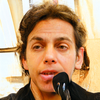

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 213.6016; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 213.6016; lr 0.0100:   1% 1/100 [00:06<10:29,  6.35s/it]
seed_1: loss 190.4013; lr 0.0100:   1% 1/100 [00:06<10:29,  6.35s/it]
seed_1: loss 190.4013; lr 0.0100:   2% 2/100 [00:06<07:26,  4.55s/it]
seed_1: loss 172.9704; lr 0.0100:   2% 2/100 [00:07<07:26,  4.55s/it]
seed_1: loss 172.9704; lr 0.0100:   3% 3/100 [00:07<05:19,  3.29s/it]
seed_1: loss 160.9615; lr 0.0100:   3% 3/100 [00:07<05:19,  3.29s/it]
seed_1: los

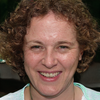

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 179.4404; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 179.4404; lr 0.0100:   1% 1/100 [00:06<10:52,  6.59s/it]
seed_1: loss 149.7431; lr 0.0100:   1% 1/100 [00:06<10:52,  6.59s/it]
seed_1: loss 149.7431; lr 0.0100:   2% 2/100 [00:06<07:42,  4.72s/it]
seed_1: loss 132.8100; lr 0.0100:   2% 2/100 [00:07<07:42,  4.72s/it]
seed_1: loss 132.8100; lr 0.0100:   3% 3/100 [00:07<05:30,  3.41s/it]
seed_1: loss 123.5504; lr 0.0100:   3% 3/100 [00:07<05:30,  3.41s/it]
seed_1: los

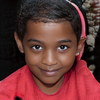

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 198.0663; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 198.0663; lr 0.0100:   1% 1/100 [00:06<10:38,  6.45s/it]
seed_1: loss 176.5289; lr 0.0100:   1% 1/100 [00:06<10:38,  6.45s/it]
seed_1: loss 176.5289; lr 0.0100:   2% 2/100 [00:06<07:32,  4.62s/it]
seed_1: loss 162.1802; lr 0.0100:   2% 2/100 [00:07<07:32,  4.62s/it]
seed_1: loss 162.1802; lr 0.0100:   3% 3/100 [00:07<05:24,  3.34s/it]
seed_1: loss 153.0667; lr 0.0100:   3% 3/100 [00:07<05:24,  3.34s/it]
seed_1: los

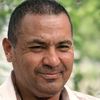

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 200.3383; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 200.3383; lr 0.0100:   1% 1/100 [00:06<10:44,  6.51s/it]
seed_1: loss 177.3994; lr 0.0100:   1% 1/100 [00:06<10:44,  6.51s/it]
seed_1: loss 177.3994; lr 0.0100:   2% 2/100 [00:06<07:36,  4.66s/it]
seed_1: loss 162.3459; lr 0.0100:   2% 2/100 [00:07<07:36,  4.66s/it]
seed_1: loss 162.3459; lr 0.0100:   3% 3/100 [00:07<05:26,  3.37s/it]
seed_1: loss 150.2673; lr 0.0100:   3% 3/100 [00:07<05:26,  3.37s/it]
seed_1: los

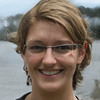

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 174.3917; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 174.3917; lr 0.0100:   1% 1/100 [00:06<10:31,  6.38s/it]
seed_1: loss 150.3670; lr 0.0100:   1% 1/100 [00:06<10:31,  6.38s/it]
seed_1: loss 150.3670; lr 0.0100:   2% 2/100 [00:06<07:28,  4.57s/it]
seed_1: loss 137.4152; lr 0.0100:   2% 2/100 [00:07<07:28,  4.57s/it]
seed_1: loss 137.4152; lr 0.0100:   3% 3/100 [00:07<05:20,  3.31s/it]
seed_1: loss 130.9417; lr 0.0100:   3% 3/100 [00:07<05:20,  3.31s/it]
seed_1: los

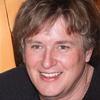

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 182.7327; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 182.7327; lr 0.0100:   1% 1/100 [00:06<10:38,  6.45s/it]
seed_1: loss 163.9785; lr 0.0100:   1% 1/100 [00:06<10:38,  6.45s/it]
seed_1: loss 163.9785; lr 0.0100:   2% 2/100 [00:06<07:32,  4.62s/it]
seed_1: loss 151.7095; lr 0.0100:   2% 2/100 [00:07<07:32,  4.62s/it]
seed_1: loss 151.7095; lr 0.0100:   3% 3/100 [00:07<05:24,  3.34s/it]
seed_1: loss 143.1975; lr 0.0100:   3% 3/100 [00:07<05:24,  3.34s/it]
seed_1: los

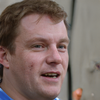

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 185.9429; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 185.9429; lr 0.0100:   1% 1/100 [00:06<10:32,  6.39s/it]
seed_1: loss 159.0258; lr 0.0100:   1% 1/100 [00:06<10:32,  6.39s/it]
seed_1: loss 159.0258; lr 0.0100:   2% 2/100 [00:06<07:28,  4.58s/it]
seed_1: loss 144.7015; lr 0.0100:   2% 2/100 [00:07<07:28,  4.58s/it]
seed_1: loss 144.7015; lr 0.0100:   3% 3/100 [00:07<05:21,  3.31s/it]
seed_1: loss 135.7850; lr 0.0100:   3% 3/100 [00:07<05:21,  3.31s/it]
seed_1: los

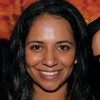

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 189.0031; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 189.0031; lr 0.0100:   1% 1/100 [00:06<10:35,  6.42s/it]
seed_1: loss 166.4622; lr 0.0100:   1% 1/100 [00:06<10:35,  6.42s/it]
seed_1: loss 166.4622; lr 0.0100:   2% 2/100 [00:06<07:30,  4.60s/it]
seed_1: loss 151.3059; lr 0.0100:   2% 2/100 [00:07<07:30,  4.60s/it]
seed_1: loss 151.3059; lr 0.0100:   3% 3/100 [00:07<05:22,  3.32s/it]
seed_1: loss 139.6764; lr 0.0100:   3% 3/100 [00:07<05:22,  3.32s/it]
seed_1: los

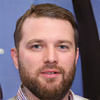

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 171.0474; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 171.0474; lr 0.0100:   1% 1/100 [00:06<10:30,  6.37s/it]
seed_1: loss 150.6154; lr 0.0100:   1% 1/100 [00:06<10:30,  6.37s/it]
seed_1: loss 150.6154; lr 0.0100:   2% 2/100 [00:06<07:27,  4.56s/it]
seed_1: loss 137.9058; lr 0.0100:   2% 2/100 [00:07<07:27,  4.56s/it]
seed_1: loss 137.9058; lr 0.0100:   3% 3/100 [00:07<05:20,  3.30s/it]
seed_1: loss 129.1105; lr 0.0100:   3% 3/100 [00:07<05:20,  3.30s/it]
seed_1: los

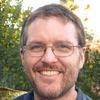

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 198.6518; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 198.6518; lr 0.0100:   1% 1/100 [00:06<10:31,  6.38s/it]
seed_1: loss 173.8253; lr 0.0100:   1% 1/100 [00:06<10:31,  6.38s/it]
seed_1: loss 173.8253; lr 0.0100:   2% 2/100 [00:06<07:27,  4.57s/it]
seed_1: loss 155.8368; lr 0.0100:   2% 2/100 [00:07<07:27,  4.57s/it]
seed_1: loss 155.8368; lr 0.0100:   3% 3/100 [00:07<05:20,  3.30s/it]
seed_1: loss 142.7690; lr 0.0100:   3% 3/100 [00:07<05:20,  3.30s/it]
seed_1: los

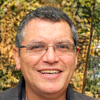

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 177.5616; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 177.5616; lr 0.0100:   1% 1/100 [00:06<10:43,  6.50s/it]
seed_1: loss 158.9558; lr 0.0100:   1% 1/100 [00:06<10:43,  6.50s/it]
seed_1: loss 158.9558; lr 0.0100:   2% 2/100 [00:06<07:36,  4.66s/it]
seed_1: loss 145.6198; lr 0.0100:   2% 2/100 [00:07<07:36,  4.66s/it]
seed_1: loss 145.6198; lr 0.0100:   3% 3/100 [00:07<05:26,  3.37s/it]
seed_1: loss 136.1754; lr 0.0100:   3% 3/100 [00:07<05:26,  3.37s/it]
seed_1: los

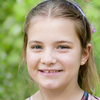

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 195.7619; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 195.7619; lr 0.0100:   1% 1/100 [00:06<10:33,  6.40s/it]
seed_1: loss 168.8531; lr 0.0100:   1% 1/100 [00:06<10:33,  6.40s/it]
seed_1: loss 168.8531; lr 0.0100:   2% 2/100 [00:06<07:29,  4.58s/it]
seed_1: loss 150.4207; lr 0.0100:   2% 2/100 [00:07<07:29,  4.58s/it]
seed_1: loss 150.4207; lr 0.0100:   3% 3/100 [00:07<05:21,  3.31s/it]
seed_1: loss 132.7251; lr 0.0100:   3% 3/100 [00:07<05:21,  3.31s/it]
seed_1: los

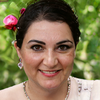

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 179.2525; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 179.2525; lr 0.0100:   1% 1/100 [00:06<10:35,  6.42s/it]
seed_1: loss 160.8825; lr 0.0100:   1% 1/100 [00:06<10:35,  6.42s/it]
seed_1: loss 160.8825; lr 0.0100:   2% 2/100 [00:06<07:31,  4.60s/it]
seed_1: loss 144.7205; lr 0.0100:   2% 2/100 [00:07<07:31,  4.60s/it]
seed_1: loss 144.7205; lr 0.0100:   3% 3/100 [00:07<05:22,  3.33s/it]
seed_1: loss 136.7979; lr 0.0100:   3% 3/100 [00:07<05:22,  3.33s/it]
seed_1: los

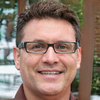

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 172.6589; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 172.6589; lr 0.0100:   1% 1/100 [00:06<10:37,  6.44s/it]
seed_1: loss 152.9169; lr 0.0100:   1% 1/100 [00:06<10:37,  6.44s/it]
seed_1: loss 152.9169; lr 0.0100:   2% 2/100 [00:06<07:32,  4.62s/it]
seed_1: loss 140.7637; lr 0.0100:   2% 2/100 [00:07<07:32,  4.62s/it]
seed_1: loss 140.7637; lr 0.0100:   3% 3/100 [00:07<05:23,  3.34s/it]
seed_1: loss 133.7086; lr 0.0100:   3% 3/100 [00:07<05:23,  3.34s/it]
seed_1: los

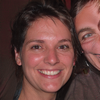

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 181.2570; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 181.2570; lr 0.0100:   1% 1/100 [00:06<10:46,  6.53s/it]
seed_1: loss 154.0039; lr 0.0100:   1% 1/100 [00:06<10:46,  6.53s/it]
seed_1: loss 154.0039; lr 0.0100:   2% 2/100 [00:06<07:38,  4.68s/it]
seed_1: loss 135.7979; lr 0.0100:   2% 2/100 [00:07<07:38,  4.68s/it]
seed_1: loss 135.7979; lr 0.0100:   3% 3/100 [00:07<05:27,  3.38s/it]
seed_1: loss 124.1444; lr 0.0100:   3% 3/100 [00:07<05:27,  3.38s/it]
seed_1: los

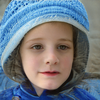

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 188.0367; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 188.0367; lr 0.0100:   1% 1/100 [00:06<10:48,  6.55s/it]
seed_1: loss 170.0184; lr 0.0100:   1% 1/100 [00:06<10:48,  6.55s/it]
seed_1: loss 170.0184; lr 0.0100:   2% 2/100 [00:06<07:40,  4.69s/it]
seed_1: loss 156.9189; lr 0.0100:   2% 2/100 [00:07<07:40,  4.69s/it]
seed_1: loss 156.9189; lr 0.0100:   3% 3/100 [00:07<05:29,  3.39s/it]
seed_1: loss 147.2105; lr 0.0100:   3% 3/100 [00:07<05:29,  3.39s/it]
seed_1: los

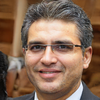

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 183.5427; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 183.5427; lr 0.0100:   1% 1/100 [00:06<10:43,  6.50s/it]
seed_1: loss 160.2095; lr 0.0100:   1% 1/100 [00:06<10:43,  6.50s/it]
seed_1: loss 160.2095; lr 0.0100:   2% 2/100 [00:06<07:36,  4.66s/it]
seed_1: loss 145.9034; lr 0.0100:   2% 2/100 [00:07<07:36,  4.66s/it]
seed_1: loss 145.9034; lr 0.0100:   3% 3/100 [00:07<05:26,  3.37s/it]
seed_1: loss 134.7031; lr 0.0100:   3% 3/100 [00:07<05:26,  3.37s/it]
seed_1: los

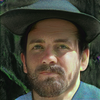

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







0it [00:00, ?it/s]
  0% 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /content/BSM_stylegan/encoder/perceptual_model.py:239: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

seed_1: loss 199.0714; lr 0.0100:   0% 0/100 [00:06<?, ?it/s]
seed_1: loss 199.0714; lr 0.0100:   1% 1/100 [00:06<10:42,  6.49s/it]
seed_1: loss 174.3643; lr 0.0100:   1% 1/100 [00:06<10:42,  6.49s/it]
seed_1: loss 174.3643; lr 0.0100:   2% 2/100 [00:06<07:35,  4.65s/it]
seed_1: loss 157.9823; lr 0.0100:   2% 2/100 [00:07<07:35,  4.65s/it]
seed_1: loss 157.9823; lr 0.0100:   3% 3/100 [00:07<05:25,  3.36s/it]
seed_1: loss 146.0125; lr 0.0100:   3% 3/100 [00:07<05:25,  3.36s/it]
seed_1: los

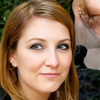

/content/BSM_stylegan



Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Traceback (most recent call last):
  File "/content/BSM_stylegan/dnnlib/tflib/network.py", line 155, in _init_graph
    out_expr = self._build_func(*self.input_templates, **build_kwargs)
  File "<string>", line 532, in G_synthesis
  File "<string>", line 518, in torgb
  File "<string>", line 157, in conv2d
  File "<string>", line 140, in get_weight
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/variable_scope.py", line 1500, in get_variable
    aggregation=aggregation)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/variable_scope.py", line 1243, in get_variable
    aggregation=aggregation)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/variable_scope.py", line 567, in get_variable
    aggregation=aggregation)
  File "/usr/local/lib/python3.6/dist-package

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7ffb1dd21620> (for post_execute):


KeyboardInterrupt: ignored

In [26]:
#Repeat until both age and gender are the same
for i in range(seed):
  #src_image=generate_image(seed)
  print(i)
  rnd=np.random.RandomState(i)
  init_latent1=rnd.randn(1, Gs.input_shape[1])[0]
  applier1 = lambda f: apply_latent_fudge(f, init_latent1)
  latent1=np.array(list(map(applier1, interpolate)))
  image = Gs.run(latent1, None, **synthesis_kwargs)
  img = PIL.Image.fromarray(image[0], 'RGB')
  img = img.resize((image_dim, image_dim), PIL.Image.ANTIALIAS)
  display(img)
  img.save('/content/BSM_stylegan/raw_images/seed.jpg')
  
  #src_image to npy
  %cd '/content/BSM_stylegan'
  #--batch_size=2 --iterations=100 --use_l1_penalty=0.2 
  !python npy_encoder.py seed.jpg --batch_size=2 --lr=0.01 --iterations=100 raw_images/ aligned_images/ generated_images/ latent_representation/
  src_file=np.load('/content/BSM_stylegan/latent_representation/seed_1.npy')
  #Style mix
  style_mixing(os.path.join('/content/gdrive/My Drive/data/style_result', 'mix_result.png'), Gs, w=1024, h=1024, src_dlatents=src_file.reshape((1, 18, 512)), dst_dlatents=test_file.reshape((1, 18, 512)), style_ranges=[range(6, 14)])
  #Detect age and gender of two photo
  ag_detection.test(dst_image)
  age1 = ag_detection.age
  gender1 = ag_detection.gender
  #Mixing photo crop
  img = Image.open('/content/gdrive/My Drive/data/style_result/mix_result.png')
  crop_img = img.crop((1024, 1024, 2048, 2048))
  crop_img.save('/content/gdrive/My Drive/data/style_result/mix.png')
  
  ag_detection.test('/content/gdrive/My Drive/data/style_result/mix.png')
  age2 = ag_detection.age
  gender2 = ag_detection.gender
  if age1 == age2 and gender1 == gender2:
    comp=0#same person
  else:
    comp=1#different person
  if comp == 0:
    break